In [ ]:
!pip install textblob
!pip install sentence_transformers
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=472f8475327226985901e316ac296f5f755d3b371f77f2704ca7becbd487f45f
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers
Looking in indexes: https://pypi.

In [ ]:
import re
import pandas as pd
from textblob import TextBlob
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from bertopic.representation import MaximalMarginalRelevance


import nltk
nltk.download('stopwords')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
%%time
dfs = []
seed_topic_list = []

verticals = ["hardware_asic","cloud_computing","data_science","devops","embedded","it_support","network","project_mgmt","web","info_security"]
#verticals = ["hardware_asic"]

for vertical in verticals:
  #file = vertical+'.xlsx'
  temp_df = pd.read_excel(f'{vertical}.xlsx')
  dfs.append(temp_df)

  #check all the skills keyword and prepare seeds
  temp_df.fillna('', inplace=True)
  temp_df['skills']  = temp_df['skills'].str.lower()
  skills = temp_df.skills.tolist()
  skills = list(filter(None, skills))

  temp_skills = [x.split(',') for x in skills]
  unique_skills = []
  for x in temp_skills:
    unique_skills = unique_skills+x
  
  unique_skills = [x.strip() for x in unique_skills if x.strip() != '']

  #clean null values from list
  unique_skills = list(set(unique_skills))
  if(len(unique_skills) !=0):
    seed_topic_list.append(unique_skills)
  else:
    print("Could not see - ",vertical)

  del temp_df

df = pd.concat(dfs, sort=False, ignore_index=True)
del dfs

Could not see -  project_mgmt
CPU times: user 2.87 s, sys: 61.1 ms, total: 2.93 s
Wall time: 3.25 s


In [ ]:
seed_topic_list

[['ajax',
  'hibernate',
  'technical support executive',
  'telesales',
  'monitoring tools',
  'powerbi',
  'db2',
  'pc maintenance',
  'jcl',
  'flex ray',
  'ccna certified',
  'image processing',
  'electronics manufacturing',
  'servicing',
  'arm7',
  'soc design',
  'rhce',
  'l1',
  'video conferencing',
  'product development',
  'requirement engineering',
  'hardware abstraction layer',
  'system integration',
  'ip networking',
  'network monitoring',
  'end user computing',
  'asic design verification',
  'developing firmware',
  'solution design',
  'netapp storage',
  'vlsi',
  'security audit',
  'wireline leased line',
  'spi',
  'stress analysis',
  'l3 chip level engineer',
  'troubleshoots',
  'shell',
  'verification and validation',
  'sales support',
  'fire safety',
  'windows troubleshooting',
  'vdi',
  'ip verification',
  'embedded software architecture',
  'os internals',
  'scheduling',
  'salesforce',
  'hardware security module',
  'ece',
  'senior engi

In [ ]:
df.head()

,job_title,company,location,date,job_desc,skills,link
0,ASIC Design Engineer - Hardware,NVIDIA,"Bengaluru, Karnataka",PostedPosted 30+ days ago,We are now looking for a ASIC Design Engineer ...,,NaN
1,"Physical Design and Implementation Engineer, ASIC",Google,"Bengaluru, Karnataka",PostedPosted 30+ days ago,Minimum qualifications:\n \n Bachelor's degr...,,NaN
2,ASIC Design Engineer - Hardware,Oski Technology,"Bengaluru, Karnataka",PostedPosted 30+ days ago,We are now looking for a ASIC Design Engineer ...,,NaN
3,Elect Design - Staff Elect Design Engr,Infineon Technologies,"Bengaluru, Karnataka",PostedPosted 30+ days ago,Design and development of USB 3.0/3.1/4.0 USB-...,,NaN
4,Director Design Engineering,Infineon Technologies,"Bengaluru, Karnataka",PostedPosted 30+ days ago,Strong interpersonal skills and ability to est...,,NaN


In [ ]:
df.fillna('', inplace=True)

In [ ]:
#Extract noun, and noun phrases job desc
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

punc_list = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']

def remove_puncutation(text,punc_list=punc_list):
  for punc  in punc_list:
    text = text.replace(punc, '')
  return text

def remove_extra_space(text):
  return " ".join(text.split())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from nltk.corpus import stopwords 

df['clean_job']  = df['job_desc'].str.lower()
df['clean_job'] = df['clean_job'].apply(remove_puncutation)
df['clean_job'] = df['clean_job'].apply(remove_extra_space)
df['clean_job'] = df['clean_job'].str.replace('\d+', '')

stop_words = stopwords.words('english')
df['clean_job'] = df['clean_job'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['clean_job'] = df['clean_job'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))


In [ ]:
def get_noun_phrases(sentence):
  blob = TextBlob(sentence)
  #return blob.noun_phrases 
  return [w for (w, pos) in TextBlob(sentence).pos_tags if pos[0] == 'N']

In [ ]:
%%time 
df['clean_job'] = df['clean_job'].apply(get_noun_phrases)

CPU times: user 2min 52s, sys: 1.12 s, total: 2min 53s
Wall time: 3min 1s


In [ ]:
df['clean_job']

0        [design, engineer, hardware, member, backendti...
1        [qualifications, bachelors, engineering, exper...
2        [design, engineer, hardware, member, backendti...
3        [design, development, data, pd, controller, ip...
4        [skills, ability, relationships, variety, peop...
                               ...                        
13382    [candidate, job, opportunity, mnc, security, e...
13383    [conduct, vulnerability, penetration, configur...
13384    [skillsinformation, security, industry, experi...
13385    [experience, workday, core, recruitingknowledg...
13386    [role, role, contributor, infrastructure, secu...
Name: clean_job, Length: 13387, dtype: object

In [ ]:
#convert list to string
df['clean_job'] = [','.join(map(str.strip, l)) for l in df['clean_job']]

In [ ]:
df['clean_job'] = df['clean_job']+df['skills']

In [ ]:
#print(len(unpreprocessed_corpus),len(preprocessed_documents))
df.to_excel(r'clean_data.xlsx', index=False)

In [ ]:
preprocessed_documents = df.clean_job.tolist()

In [ ]:
preprocessed_documents[:5]

['design,engineer,hardware,member,backendtiming,team,youll,product,designs,tasks,clocks,convergence,chip,design,optimization,automation,work,chip,clock,distribution,chip,closure,signoff,tools,cadence,tempus,design,optimization,design,role,architecture,rtl,design,layout,implementation,methodology,custom,design,teams,design,implementation,timing,analysisclosure,way,youll,enhance,work,flow,chip,block,level,chip,integration,floor,planning,custom,scripts,clock,skew,analysis,circuits,clock,dividers,io,macros,interfaces,design,optimization,convergence,tasks,development,pd,work,flows,engineering,computer,science,experience,years,design,experience,technology,employers,people,hear',
 'qualifications,bachelors,engineering,experience,years,design,experience,performance,synthesis,optimizations,experience,convergence,checks,verification,experience,synthesispnr,genus,innovus,dc,icc,qualifications,computer,architecture,knowledge,verilogsystemverilog,circuit,design,device,physics,submicron,technology,s

In [ ]:
%%time 

from bertopic import BERTopic
import tensorflow_hub
#embedding_model = tensorflow_hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(preprocessed_documents, show_progress_bar=False)
representation_model = MaximalMarginalRelevance(diversity=0.5)

topic_model = BERTopic(n_gram_range=(1,3),seed_topic_list=seed_topic_list,embedding_model=sentence_model,representation_model=representation_model)
topics, probs = topic_model.fit_transform(preprocessed_documents)

CPU times: user 4min 59s, sys: 8.27 s, total: 5min 7s
Wall time: 4min 52s


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4171,-1_development_management_software_experience
1,0,805,0_joiners___
2,1,718,1_analytics_business_python_ml
3,2,625,2_compliance_cybersecurity_audit_risk management
4,3,336,3_cisco_vpn_configuration_routing
...,...,...,...
233,232,10,232_svg_web_components collaboration skills_to...
234,233,10,233_pcb_transmission line_hardware design deve...
235,234,10,234_wcag_user interface_javascript_developers
236,235,10,235_operating plan_metrics ad_month end proces...


In [ ]:
topic_model.visualize_barchart()


In [ ]:
topic_term_matrix = topic_model.c_tf_idf_

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

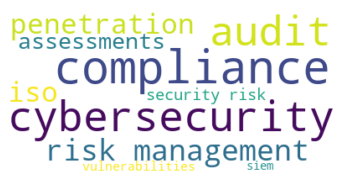

In [ ]:
# Show wordcloud
create_wordcloud(topic_model, topic=2)

In [ ]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,4171,-1_development_management_software_experience
1,0,805,0_joiners___
2,1,718,1_analytics_business_python_ml
3,2,625,2_compliance_cybersecurity_audit_risk management
4,3,336,3_cisco_vpn_configuration_routing
5,4,202,4_rtos_spi_arm_linux
6,5,186,5_project management_budget_scope_stakeholders
7,6,167,6_jenkins_devops_kubernetes_docker
8,7,132,7_terraform_rds_devops_monitoring
9,8,130,8_database_applications_fusion_experience oracle


In [ ]:
import pickle

def save_model(model_filename, model):
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)

save_model("bert_model.pkl",topic_model)

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4171,-1_development_management_software_experience
1,0,805,0_joiners___
2,1,718,1_analytics_business_python_ml
3,2,625,2_compliance_cybersecurity_audit_risk management
4,3,336,3_cisco_vpn_configuration_routing
...,...,...,...
233,232,10,232_svg_web_components collaboration skills_to...
234,233,10,233_pcb_transmission line_hardware design deve...
235,234,10,234_wcag_user interface_javascript_developers
236,235,10,235_operating plan_metrics ad_month end proces...


In [ ]:
topic_model.get_topic(0)

[('joiners', 5.01587897451687),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05),
 ('', 1e-05)]

In [ ]:
topic_model.get_topic(1)

[('analytics', 0.011817915808233478),
 ('business', 0.0060184769821506785),
 ('python', 0.005730212095186554),
 ('ml', 0.004696962593257068),
 ('sql', 0.004380417255732394),
 ('data scientist', 0.004277411564942497),
 ('experience', 0.00357195355977555),
 ('modeling', 0.003548933040822953),
 ('solutions', 0.0035410627982851357),
 ('data mining', 0.0032409195712633575)]

In [ ]:
topic_model.get_topic(2)

[('compliance', 0.006032798794311641),
 ('cybersecurity', 0.004863269304849367),
 ('audit', 0.004607461545462638),
 ('risk management', 0.004432274221039473),
 ('penetration', 0.004029502374784058),
 ('iso', 0.004009970026327323),
 ('assessments', 0.003866821566302004),
 ('security risk', 0.0035791784653724946),
 ('vulnerabilities', 0.003308609329565623),
 ('siem', 0.003050747934066553)]

In [ ]:
topic_model.get_topic(3)

[('cisco', 0.021319565651083595),
 ('vpn', 0.007026682067392626),
 ('configuration', 0.0069761542499619964),
 ('routing', 0.006919255164164469),
 ('firewalls', 0.006610887986311895),
 ('palo', 0.005934962175010998),
 ('switching', 0.005170348853186786),
 ('ccnp', 0.004984653870653917),
 ('meraki', 0.0047542653166474155),
 ('vlan', 0.004123130929983493)]

In [ ]:
topic_model.get_topic(4)

[('rtos', 0.0166971775686535),
 ('spi', 0.015810501857954476),
 ('arm', 0.013191695826967486),
 ('linux', 0.01299392859453237),
 ('microcontroller', 0.010048620832975426),
 ('embedded systems', 0.0072881605211676396),
 ('i2c', 0.007111022011430992),
 ('debugging', 0.006274272791736802),
 ('firmware development', 0.005801730658735904),
 ('uart', 0.005566313578060174)]

In [ ]:
topic_model.get_topic(5)

[('project management', 0.009321050059814411),
 ('budget', 0.005788115449605345),
 ('scope', 0.0054285923770483755),
 ('stakeholders', 0.004603649879894717),
 ('plan', 0.004007409566321428),
 ('skills', 0.0033287777961816174),
 ('leadership', 0.0032064001136097448),
 ('experience project', 0.0030684848146395084),
 ('risks', 0.0029577447707602434),
 ('objectives', 0.0028988526786037547)]

In [ ]:
topic_model.get_topic(6)

[('jenkins', 0.020106634545182397),
 ('devops', 0.015399837207849409),
 ('kubernetes', 0.013195963618577155),
 ('docker', 0.01299369573161846),
 ('cicd', 0.009760943871530545),
 ('terraform', 0.005996429874734193),
 ('pipelines', 0.005105055783836584),
 ('gitlab', 0.0049830001760451555),
 ('configuration management', 0.004675100554058908),
 ('puppet', 0.004451720325978187)]

In [ ]:
topic_model.get_topic(7)

[('terraform', 0.007573938202262698),
 ('rds', 0.007126546629510648),
 ('devops', 0.0069776453820639284),
 ('monitoring', 0.006101226795671858),
 ('cicd', 0.005828519312691841),
 ('configuration management', 0.005250634499243575),
 ('docker', 0.005172587645331504),
 ('aws services', 0.0040857008015662034),
 ('jenkins', 0.003931986522077843),
 ('kubernetes', 0.00367717513585613)]

In [ ]:
topic_model.get_topic(8)

[('database', 0.008941793001190376),
 ('applications', 0.00552175318947013),
 ('fusion', 0.005116438654443098),
 ('experience oracle', 0.004124643423132547),
 ('oracle fusion', 0.0038794875851039883),
 ('oracles', 0.0035503290740470906),
 ('oracle cloud', 0.003489283626747847),
 ('duties tasks', 0.0031628260442449303),
 ('service', 0.0029908701180374766),
 ('member', 0.0029253179440060424)]

In [ ]:
topic_model.get_topic(9)

[('pcb', 0.01627609442936907),
 ('analog', 0.012864165967144021),
 ('simulation', 0.00948899888179849),
 ('circuit design', 0.006832952703031569),
 ('motor', 0.006363012775709144),
 ('microcontroller', 0.0063348458675931045),
 ('altium', 0.005943729642062179),
 ('emc', 0.004986045549529227),
 ('power supplies', 0.004522794038056655),
 ('development', 0.0042953235193022845)]

In [ ]:
topic_model.get_topic(10)

[('desktop', 0.02831820945144386),
 ('troubleshooting', 0.020640070447257793),
 ('technical', 0.014906113982913556),
 ('configuration', 0.012175813153820596),
 ('outlook', 0.01008800044172244),
 ('printers', 0.009334835807384777),
 ('lan', 0.009191174651174533),
 ('software installation', 0.008806652299624667),
 ('hardware support', 0.008473549925941702),
 ('client support', 0.007012172232332822)]

In [ ]:
topic_model.get_topic(11)

[('engineering business solutions', 0.009134589934547632),
 ('technology services engineering', 0.007455940509924766),
 ('bosch worlds', 0.00710147295140468),
 ('subsidiary robert bosch', 0.007088534988189928),
 ('footprint presence', 0.007088534988189928),
 ('subsidiary', 0.006839435726343526),
 ('company description', 0.006648515552377993),
 ('solutions', 0.00598125100927549),
 ('region', 0.005790795219070429),
 ('worlds supplier technology', 0.005416727283576072)]

In [ ]:
total_results = len(topic_model.get_topic_info())
topic_list = []

for i in range(1,total_results-1):
  topic_words = []
  for j in range(10):
    topic_words.append(topic_model.get_topic(i)[j][0])
  topic_list.append(topic_words)
  
#Find vertical based on most match
topic_class = 0

topic_index = 0
topic_score = 0
verticals = [[] for i in range(len(seed_topic_list))]

#check each topic one by one
skipped_words = []
for current_topic_words in topic_list:
  #match with all seed to get final index

  final_vertical_index = 0
  final_vertical_score = 0  
  index = 0
  for seeds in seed_topic_list:
    current_vertical_score = 0

    for word in current_topic_words:
      if word in seeds:
        current_vertical_score = current_vertical_score + 1
    
      if current_vertical_score > final_vertical_score:
        final_vertical_score = current_vertical_score
        final_vertical_index = index
    index = index+1
  #skip if score is less than 2
  if final_vertical_score < 4:
    for _word in current_topic_words:
      skipped_words.append(_word)
    continue  
  for _word in current_topic_words:
    verticals[final_vertical_index].append(_word)
  


In [ ]:
verticals[0]

['rtos',
 'spi',
 'arm',
 'linux',
 'microcontroller',
 'embedded systems',
 'i2c',
 'debugging',
 'firmware development',
 'uart',
 'pcb',
 'analog',
 'simulation',
 'circuit design',
 'motor',
 'microcontroller',
 'altium',
 'emc',
 'power supplies',
 'development',
 'dft',
 'design verification',
 'hardware',
 'intels',
 'verilog',
 'debug',
 'engineering',
 'experience',
 'qualifications',
 'closure',
 'it sales',
 'b2b',
 'clients',
 'lead generation',
 'relationships',
 'accounts',
 'hardware',
 'proposals',
 'sales business development',
 'business opportunities',
 'installation',
 'engineering hardware',
 'configuration',
 'support desktop',
 'system',
 'technical support',
 'network administration',
 'engineering network',
 'windows',
 'outlook knowledge directorynetworking',
 'powertrain',
 'research',
 'volvo group',
 'tools',
 'cars',
 'validation',
 'trucks technology',
 'functions',
 'systems',
 'software development',
 'knowledge azure',
 'experience',
 'project manageme

In [ ]:
len(skipped_words)

1650

In [ ]:
#check difference between seed and verticals
for i in range(len(verticals)):
  print(list(set(verticals[i]) - set(seed_topic_list[i])))

['management knowledge directory', 'sales business development', 'cars', 'rivera manpower', 'scrumagile development methodologies', 'improvement service', 'dhcp network connectivity', 'requirements', 'role level', 'system verilog pcie', 'customer', 'emulation', 'assistant store manager', 'desk technical', 'support employees', 'engineering simulation staffing', 'test effort', 'skills urge issues', 'development lint cdc', 'microprocessor integration', 'zensar', 'issues', 'directory dhcp', 'functions', 'experience jenkins', 'clients', 'ibm', 'validation domain knowledge', 'intels', 'world work', 'core mvc', 'scripting language', 'business opportunities', 'relationships', 'qualifications', 'volvo group', 'engineering hardware', 'verification simulation', 'cockpit', 'interface devices microcontroller', 'interviews', 'landscape management', 'experience hil', 'systems', 'verification team', 'issues technologies', 'shift', 'trucks technology', 'technologies', 'design synthesis timing', 'lac', 

In [ ]:
#check difference between seed and verticals
for i in range(len(verticals)):
  print(list(set(seed_topic_list[i])-set(verticals[i])))

['slas', 'bangalore', 'ajax', 'hibernate', 'it support services', 'electric vehicle', 'technical support executive', 'performance tuning', 'telesales', 'tcp socket programming', 'retail finance', 'monitoring tools', 'powerbi', 'customer support executive', 'emi/emc', 'lt spice', '16 bit 32 bit microcontroller', 'it infrastructure services', 'db2', 'cluster management', 'electrical', 'pc maintenance', 'oop', 'jcl', 'solaris administration', 'flex ray', 'ccna certified', 'image processing', 'growth strategy', 'windows administration', 'electronics manufacturing', 'mbedos', 'technical documentation', 'servicing', 'arm7', '.net', 'rhce', 'l1', 'defect tracking tool', 'video conferencing', 'automotive', 'incoming inspection', 'product development', 'requirement engineering', 'printer troubleshooting', 'hardware abstraction layer', 'system integration', 'ip networking', 'information retrieval', 'network monitoring', 'end user computing', 'asic design verification', 'developing firmware', 'pc